In [1]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
from island_ga import IslandGGA 
from chromosome import Chromosome 
import itertools

In [2]:
#rename column to remove spaces in column names
data=pd.read_csv('HistoricalQuotes.csv')
aapl =data.rename(columns={' Close/Last': 'close', ' Volume': 'volume',
                           ' Open':'open',' High':'high',' Low':'low'})
                        

#change date string into date format and sort the dataframe in ascending order
aapl[['Date']] = aapl[['Date']].applymap(lambda x: datetime.strptime(x,'%m/%d/%Y').date())
aapl =aapl.sort_values(by='Date')
#change dataframe dtypes to float
cols = [i for i in aapl if i not in ['Date','volume']]
def to_float(x):
    x = x.strip()
    return float(x[1:])

aapl[cols]=aapl[cols].applymap(to_float)

#Create Signals using Talib library
aapl['5EMA'] = ta.SMA(np.array(aapl['close']),5)
aapl['20EMA'] = ta.EMA(np.array(aapl['close']), timeperiod = 20)
aapl['RSI'] = ta.RSI(np.array(aapl['close']), timeperiod = 14)
aapl['WILLR'] = ta.WILLR(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['MOM'] = ta.MOM(np.array(aapl['close']), timeperiod=5)
aapl['CCI'] = ta.CCI(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['SLOWK'],aapl['SLOWD'] = ta.STOCH(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), fastk_period=14, slowk_period=3, slowd_period=3)
aapl['MACD'],aapl['MACDSIGNAL'],aapl['MACDHIST'] = ta.MACD(np.array(aapl['close']), fastperiod=12, slowperiod=26, signalperiod=9)
aapl['DMI'] = ta.DX(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)   

In [5]:
#  """Based on parameter setting adopted in Chen et al (2021) """
def generate_candidate_trading_signals(data):
    """Based on parameter setting adopted in Chen et al (2021) """
    conditions ={'TS1':[
                (data['5EMA'] > data['20EMA']),
                (data['5EMA'] < data['20EMA'])],
                 'TS2':[
                (data['RSI'] > 30),
                (data['RSI'] < 70),
                ],
                 'TS3':[
                (data['WILLR'] < 80),
                (data['WILLR'] > 20),
                ],
                 'TS4':[
                (data['MOM'] > 0 ),
                (data['MOM'] <= 0),
                ],
                 'TS5': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= 100),
                ],
                 'TS6': [
                (data['SLOWK'] > data['SLOWD']) & (data['SLOWD'] < 20),
                (data['SLOWK'] < data['SLOWD']) & (data['SLOWD'] > 80)],
                'TS7': [
                (data['MACD'] > 0 ),
                (data['MACD'] <= 0)],
                'TS8': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= -100)]}

    # create a list of the values we want to assign for each condition 1: buy, 0: sell
    values = [1, 0]

    # create a new column and use np.select to assign values to it using our lists as arguments
    for i in conditions:
        data[i] = np.select(conditions[i], values)
    strategies =list(conditions.keys())
    return data,strategies
#split data
train = aapl[(aapl['Date'] <= date(2019,12,31))]
test = aapl[(aapl['Date'] > date(2019,12,31))]
train_data, strategies =generate_candidate_trading_signals(train.copy())
test_data, test_strategies =generate_candidate_trading_signals(test.copy())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product  # To create grid combinations

# Define crossover and mutation rates
crossover_rates = [0.1, 0.2, 0.4, 0.6, 0.8]
mutation_rates = [0.01, 0.05, 0.1, 0.3, 0.5]

# Dictionary to store results
convergence_results = {}

# Loop through all combinations of crossover and mutation rates
for r_cross, r_mut in product(crossover_rates, mutation_rates):
    print(f"Running GA with crossover={r_cross}, mutation={r_mut}")  # To track progress
    
    # Run the GA with the given parameters
    ga = IslandGGA(data=train_data, num_islands=3, m_iter=20, num_iter=80,
                   n_migrants=30, pSize=200, r_cross=r_cross, r_mut=r_mut,
                   strategies=strategies, evolve_strategy="multikuti")
    ga.evolve()

    # Store convergence values
    convergence_results[(r_cross, r_mut)] = ga.convergence_values

# Save results as a NumPy file
np.save("grid_search_results.npy", convergence_results)

# Plot all combinations
plt.figure(figsize=(10, 8))
for (r_cross, r_mut), values in convergence_results.items():
    plt.plot(range(1, len(values) + 1), values, 
             label=f"Cross={r_cross}, Mut={r_mut}")

plt.xlabel('Iteration')
plt.ylabel('Convergence Value')
plt.title('GA Convergence for Different Crossover & Mutation Rates')
plt.legend(fontsize=8, loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()


In [7]:
# master_slave
values = []
crossover_rates =[0.1, 0.2, 0.4, 0.6, 0.8]

for i in crossover_rates:
    ga = IslandGGA(data=train_data,num_islands=3,m_iter=80,num_iter=50,pSize=200,r_cross=i,r_mut=0.01,strategies=strategies,evolve_strategy="master_slave")
    ga.evolve()
    #v =  [i[2] for i in ga.convergence_values]
    values.append(ga.convergence_values)
# convergence values for each crossover rate
convergence_values = values
file_name = 'crossover_rates_masterslave'
np.save(file_name,convergence_values)
# plot the convergence values for each crossover rate
plt.figure(figsize=(8, 6))
for i in range(len(crossover_rates)):
    plt.plot(np.arange(1, 51), convergence_values[i], label='Crossover rate = ' + str(crossover_rates[i]))
plt.xlabel('Iteration')
plt.ylabel('Convergence value')
plt.title('Convergence values for different crossover rates')
plt.legend()
plt.show()

Running master_slave


Process Process-2:
Process Process-1:
Process Process-3:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/kudakwashechideme/repos/genetic_algo_venv/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/kudakwashechideme/repos/genetic_algo_venv/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/kudakwashechideme/repos/genetic_algo_venv/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/kudakwashechideme/repos/genetic_algo_venv/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/kudakwashechideme/repos/genetic_algo_venv/lib/python3.9/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/U

KeyboardInterrupt: 

Running ring
GENERATION 0 START
Generation 0: Best fitness = 310.07205205874396 Average Fitness( last island) = 175.67986735045474
GENERATION 0 END
GENERATION 1 START
Generation 1: Best fitness = 310.07205205874396 Average Fitness( last island) = 195.87268981049147
GENERATION 1 END
GENERATION 2 START
Generation 2: Best fitness = 310.07205205874396 Average Fitness( last island) = 195.78807710045595
GENERATION 2 END
GENERATION 3 START
Generation 3: Best fitness = 367.5714428284849 Average Fitness( last island) = 195.87268981049152
GENERATION 3 END
GENERATION 4 START
Generation 4: Best fitness = 367.5714428284849 Average Fitness( last island) = 195.87268981049152
GENERATION 4 END
GENERATION 5 START
Generation 5: Best fitness = 367.5714428284849 Average Fitness( last island) = 195.87268981049152
GENERATION 5 END
GENERATION 6 START
Generation 6: Best fitness = 367.5714428284849 Average Fitness( last island) = 195.87268981049152
GENERATION 6 END
GENERATION 7 START
Generation 7: Best fitness 

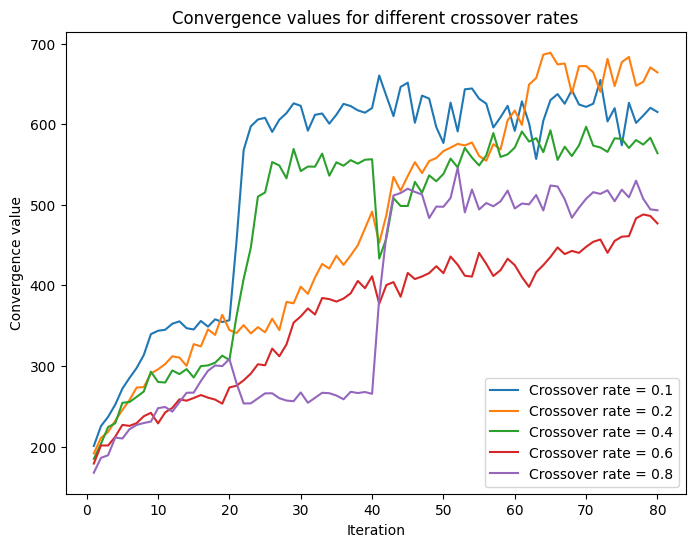

In [ ]:
# ring
values = []
crossover_rates = [0.1, 0.2, 0.4, 0.6, 0.8]

for i in crossover_rates:
    ga = IslandGGA(data=train_data,num_islands=3,m_iter=20,num_iter=50,n_migrants=30,pSize=200,r_cross=i,r_mut=0.01,strategies=strategies,evolve_strategy="ring")
    ga.evolve()
    v =  [i[2] for i in ga.convergence_values]
    values.append(v)
# convergence values for each crossover rate
convergence_values = values
file_name = 'crossover_rates_ring'
np.save(file_name,convergence_values)
# plot the convergence values for each crossover rate
plt.figure(figsize=(8, 6))
for i in range(len(crossover_rates)):
    plt.plot(np.arange(1, 51), convergence_values[i], label='Crossover rate = ' + str(crossover_rates[i]))
plt.xlabel('Iteration')
plt.ylabel('Convergence value')
plt.title('Convergence values for different crossover rates')
plt.legend()
plt.show()

Running nearest
GENERATION 0 START
Generation 0: Best fitness = 290.86275863118937 Average Fitness( last island) = 127.0599374703135
GENERATION 0 END
GENERATION 1 START
Generation 1: Best fitness = 290.86275863118937 Average Fitness( last island) = 127.0599374703135
GENERATION 1 END
GENERATION 2 START
Generation 2: Best fitness = 290.86275863118937 Average Fitness( last island) = 127.0599374703135
GENERATION 2 END
GENERATION 3 START
Generation 3: Best fitness = 290.86275863118937 Average Fitness( last island) = 127.0599374703135
GENERATION 3 END
GENERATION 4 START
Generation 4: Best fitness = 290.86275863118937 Average Fitness( last island) = 127.0599374703135
GENERATION 4 END
GENERATION 5 START
Generation 5: Best fitness = 290.86275863118937 Average Fitness( last island) = 127.0599374703135
GENERATION 5 END
Running nearest
GENERATION 0 START
Generation 0: Best fitness = 278.63575383719154 Average Fitness( last island) = 188.5662513640072
GENERATION 0 END
GENERATION 1 START
Generation 

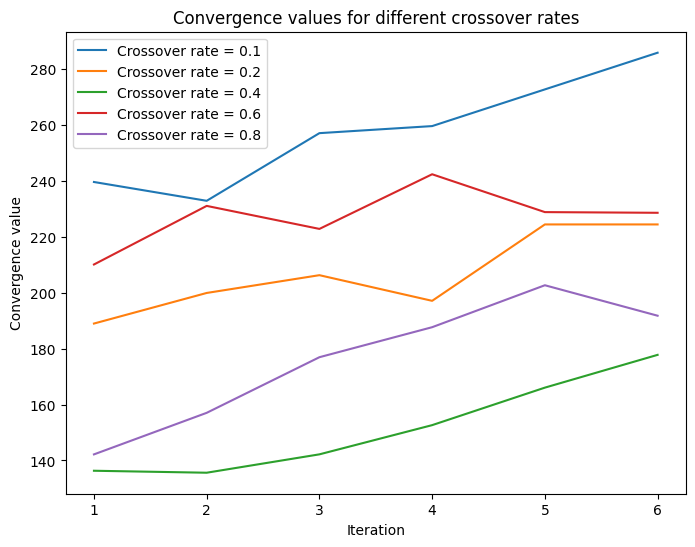

In [ ]:
# nearest
values = []
crossover_rates = [0.1, 0.2, 0.4, 0.6, 0.8]

for i in crossover_rates:
    ga = IslandGGA(data=train_data,num_islands=3,m_iter=20,num_iter=50,n_migrants=30,pSize=200,r_cross=i,r_mut=0.01,strategies=strategies,evolve_strategy="nearest")
    ga.evolve()
    v =  [i[2] for i in ga.convergence_values]
    values.append(v)
import matplotlib.pyplot as plt
import numpy as np

# convergence values for each crossover rate

convergence_values = values
file_name = 'crossover_rates_nearest'
np.save(file_name,convergence_values)
# plot the convergence values for each crossover rate
plt.figure(figsize=(8, 6))
for i in range(len(crossover_rates)):
    plt.plot(np.arange(1, 51), convergence_values[i], label='Crossover rate = ' + str(crossover_rates[i]))
plt.xlabel('Iteration')
plt.ylabel('Convergence value')
plt.title('Convergence values for different crossover rates')
plt.legend()
plt.show()

Running multikuti
GENERATION 0 START
Generation 0: Best fitness = 315.1391101954683 Average Fitness( last island) = 196.61024289178388
GENERATION 0 END
GENERATION 1 START
Generation 1: Best fitness = 315.1391101954683 Average Fitness( last island) = 186.14370482000453
GENERATION 1 END
GENERATION 2 START
Generation 2: Best fitness = 315.1391101954683 Average Fitness( last island) = 182.7078560290298
GENERATION 2 END
GENERATION 3 START
Generation 3: Best fitness = 389.98794979875515 Average Fitness( last island) = 147.49724246363215
GENERATION 3 END
GENERATION 4 START
Generation 4: Best fitness = 389.98794979875515 Average Fitness( last island) = 196.61024289178388
GENERATION 4 END
GENERATION 5 START
Generation 5: Best fitness = 389.98794979875515 Average Fitness( last island) = 196.61024289178388
GENERATION 5 END
GENERATION 6 START
Generation 6: Best fitness = 389.98794979875515 Average Fitness( last island) = 196.61024289178388
GENERATION 6 END
GENERATION 7 START
Generation 7: Best fit

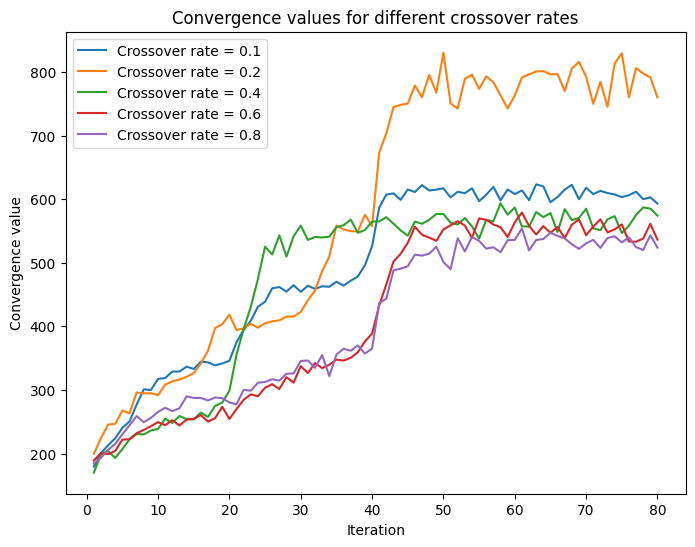

In [ ]:
# multikuti
values = []
crossover_rates = [0.1, 0.2, 0.4, 0.6, 0.8]

for i in crossover_rates:
    ga = IslandGGA(data=train_data,num_islands=3,m_iter=20,num_iter=50,n_migrants=30,pSize=200,r_cross=i,r_mut=0.01,strategies=strategies,evolve_strategy="multikuti")
    ga.evolve()
    v =  [i[2] for i in ga.convergence_values]
    values.append(v)


# convergence values for each crossover rate
convergence_values = values
file_name = 'crossover_rates_multikuti'
np.save(file_name,convergence_values)
# plot the convergence values for each crossover rate
plt.figure(figsize=(8, 6))
for i in range(len(crossover_rates)):
    plt.plot(np.arange(1, 51), convergence_values[i], label='Crossover rate = ' + str(crossover_rates[i]))
plt.xlabel('Iteration')
plt.ylabel('Convergence value')
plt.title('Convergence values for different crossover rates')
plt.legend()
plt.show()